# Load the necessary libraries

In [5]:
import pandas as pd
import numpy as np
import h5py
import analysis_data
run_info =[]

# load data for debugging

In [6]:


#file = 'outnpy/lv2415_anode_lv2414_dual_20240904_LED_2.300V_900mv_10ns_attenuator_9DB_400_ratio_run0.h5py'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240904_LED_1.085V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240904_LED_1.300V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240910_LED_1.200V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
# file = 'outnpy/lv2415_anode_lv2414_dual_20240910_LED_1.050V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
# file = 'outnpy/lv2415_anode_lv2414_dual_20240910_LED_1.000V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
# file = 'outnpy/lv2415_anode_lv2414_dual_20240910_LED_1.000V_900mv_100ns_attenuator_9DB_400_ratio_run1.h5py'
# file = 'outnpy/lv2415_anode_lv2414_dual_20240910_LED_1.050V_900mv_100ns_attenuator_9DB_400_ratio_run1.h5py'
# file = 'outnpy/lv2415_anode_lv2414_dual_20240910_LED_1.070V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
# file = 'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.060V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py' 
# file  = 'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.055V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
# file  = 'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.075V_900mv_100ns_attenuator_9DB_400_ratio_run1.h5py'
# file  = 'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.080V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
# file  = 'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.085V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
# file  = 'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.095V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
# file  = 'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.110V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
# file  = 'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.120V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
# file = 'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.130V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
# file  = 'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.140V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
# file = 'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.145V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
# file = 'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.150V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
# file = 'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.160V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
# file = 'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.170V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
# file  = 'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.180V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'
#file  =   'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.190V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5py'


#file  = 'outnpy/lv2415_anode_lv2414_dual_20240904_LED_1.300V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file  = 'outnpy/lv2415_anode_lv2414_dual_20240910_LED_1.200V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file  = 'outnpy/lv2415_anode_lv2414_dual_20240910_LED_1.050V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file  = 'outnpy/lv2415_anode_lv2414_dual_20240910_LED_1.000V_900mv_100ns_attenuator_9DB_400_ratio_run1.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240910_LED_1.070V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240910_LED_1.100V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.055V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240920_LED_1.060V_900mv_100ns_attenuator_9DB_400_ratio_run1.h5df'

##### day 2024 09 24 ####
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.075V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.000V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_950mv_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_980mv_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_965mv_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.010V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.020V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.030V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.050V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.040V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.060V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.070V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.080V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.090V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.100V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.120V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.140V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.160V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.180V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.200V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.240V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.280V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20240924_LED_1.300V_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'



#file = 'outnpy/lv2415_anode_lv2414_dual_20240829_LED_1.075V_100ns_400_ratio_run0.h5py'


#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_965mV_900mv_100ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_1.010V_900mv_300ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_920mv_900mv_200ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_930mv_900mv_300ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_930mv_900mv_300ns_attenuator_9DB_400_ratio_run1.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_915mv_900mv_300ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_910mv_900mv_300ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_900mv_900mv_300ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_900mv_900mv_400ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_850mv_900mv_400ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_880mv_900mv_400ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_885mv_900mv_400ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_890mv_900mv_400ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_888mv_900mv_400ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_850mv_900mv_500ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_870mv_900mv_500ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_890mv_900mv_500ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_888mv_900mv_500ns_attenuator_9DB_400_ratio_run0.h5df'
#file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_887mv_900mv_500ns_attenuator_9DB_400_ratio_run0.h5df'
file = 'outnpy/lv2415_anode_lv2414_dual_20241011_LED_885mv_900mv_500ns_attenuator_9DB_400_ratio_run0.h5df'

In [7]:
file_date = file.split('LED_')[0].split('dual_')[1]
led_config = file.split('LED_')[1].split('_400_ratio')[0]
file_tag = file_date + led_config
file_tag


'20241011_885mv_900mv_500ns_attenuator_9DB'

In [8]:
df = pd.read_hdf(file, key='winfo')
df.head()

,Ch,TTT,Baseline,Hight,St,Ed,Minp,Width,Area,Area_fixrange,Wave
0,0,35712,15170,5845.68,178,181,180,3,188.432595,5343.985294,"[15175, 15169, 15169, 15166, 15173, 15171, 151..."
1,1,35712,15324,534.00,212,217,215,5,12.362099,66.151150,"[15328, 15324, 15321, 15324, 15321, 15324, 153..."
2,2,35712,8112,5.00,1,4,2,3,0.000000,-46.380687,"[8114, 8115, 8107, 8114, 8117, 8112, 8112, 811..."
3,0,285708,15169,5862.24,216,222,218,6,390.595827,5360.057590,"[15169, 15167, 15171, 15171, 15169, 15171, 151..."
4,1,285708,15325,302.00,189,192,190,3,4.402516,65.367564,"[15328, 15326, 15326, 15322, 15326, 15321, 153..."


In [9]:
n =0
ch_0 = df.Ch[:][n]
wave_0 = df.Wave[:][n]
baseline_0 = df.Baseline[:][n]
st = 90
ed = 180
mp = 120
ttt_0 =  df.TTT[:][n]
area_0 = df.Area_fixrange[:][n]

m =2
ch_1 = df.Ch[:][m]
wave_2 = df.Wave[:][m]
baseline_2 = df.Baseline[:][m]
ttt_2 = df.TTT[:][m]
area_2 = df.Area_fixrange[:][m]


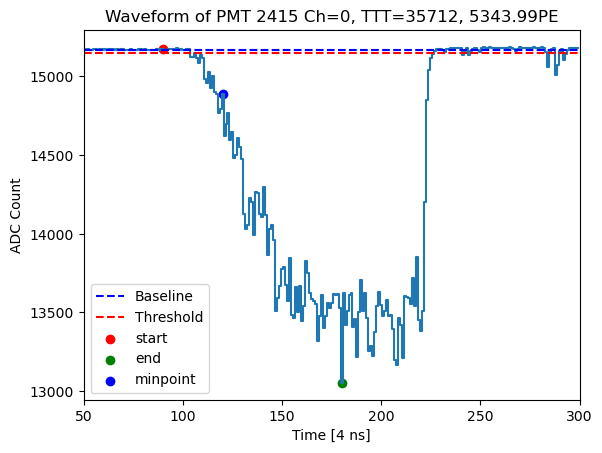

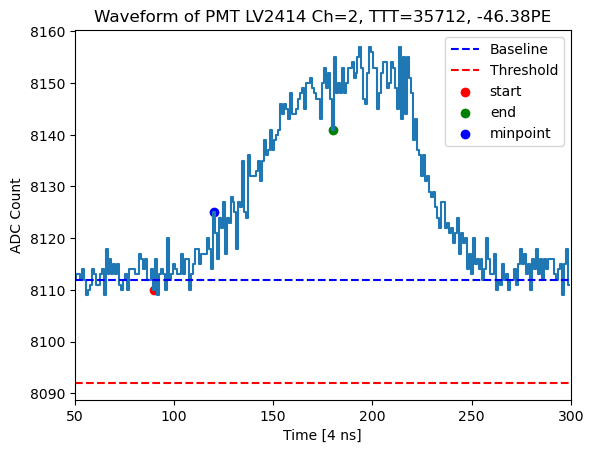

In [10]:

analysis_data.plot_waveform(wave_0, baseline_0, st, ed, mp, 50,300, pmt='2415',ch=r'Ch={}'.format(ch_0), ttt=ttt_0, area=area_0)
analysis_data.plot_waveform(wave_2, baseline_2, st, ed, mp, 50,300, pmt='LV2414', ch=r'Ch={}'.format(ch_1),  ttt=ttt_2, area=area_2)


In [11]:
area_ch0 = df.Area_fixrange[df.Ch==0 ].astype(np.float64).to_numpy()
area_ch1 = df.Area_fixrange[df.Ch==1 ].astype(np.float64).to_numpy()
area_ch2 = df.Area_fixrange[df.Ch==2 ].astype(np.float64).to_numpy()
# width_ch0 = df.Width[df.Ch==0 ].astype(np.float64).to_numpy()
# hight_ch0 = df.Hight[df.Ch==0 ].astype(np.float64).to_numpy()

In [12]:
area_ch0, area_ch1, area_ch2

(array([5343.98529393, 5360.05759021, 5267.38465889, ..., 5286.0824517 ,
        5321.77501253, 5278.84459642]),
 array([66.1511496 , 65.36756367, 72.87349211, ..., 53.89215383,
        56.42849778, 65.88308073]),
 array([-46.38068671, -45.3265802 , -44.11821419, ..., -43.51403119,
        -44.27247368, -47.58905272]))

# define the range and number of bins to fit histogram of area distribution

In [13]:
ratio = area_ch0/area_ch1
mean_ch0 = np.mean(area_ch0)
std_ch0 = np.std(area_ch0)
nbins_ch0 = round(np.max(area_ch0)-np.min(area_ch0))
left_edge_ch0 = np.min(area_ch0)
right_edge_ch0 = np.max(area_ch0)
amplitude_ch0 = len(area_ch0)

mean_ch1 = np.mean(area_ch1)
std_ch1 = np.std(area_ch1)
nbins_ch1 = round(np.max(area_ch1)-np.min(area_ch1))
left_edge_ch1 = np.min(area_ch1)
right_edge_ch1 = np.max(area_ch1)
amplitude_ch1 = len(area_ch1)

mean_ch2 = np.mean(-area_ch2)
std_ch2 = np.std(-area_ch2)
nbins_ch2 = round(np.max(-area_ch2)-np.min(-area_ch2))
left_edge_ch2 = np.min(-area_ch2)
right_edge_ch2 = np.max(-area_ch2)
amplitude_ch2 = len(-area_ch2)
   

In [14]:
mean_ch2, std_ch2 ,left_edge_ch2 , right_edge_ch2, nbins_ch2 , amplitude_ch2

(43.27357720166702,
 1.6044458354500961,
 36.34096489311103,
 50.67424252162847,
 14,
 128668)

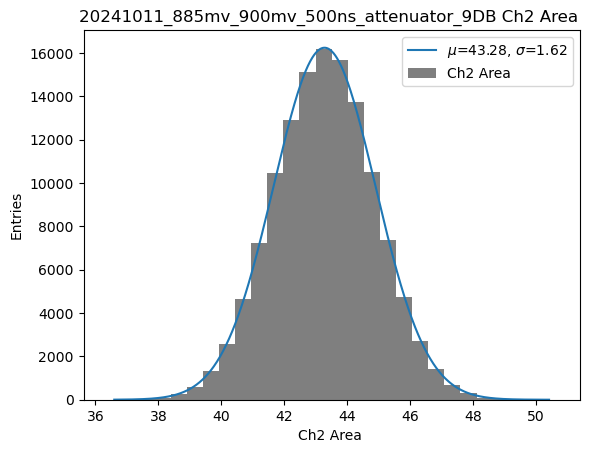

Fit: mu= 43.28, sigma =1.62


In [15]:
#Ch2_area_pe_mu, Ch2_area_pe_sigma =  analysis_data.plot_fit_histgram_vs_Gaussion(-area_ch2, 100, 10 ,100, [1e3, 50, 10 ], file_tag=file_tag, xlabel='Ch2 Area', title='Ch2 Area ')
Ch2_area_pe_mu, Ch2_area_pe_sigma =  analysis_data.plot_fit_histgram_vs_Gaussion(-area_ch2, nbins_ch2*2, left_edge_ch2 ,right_edge_ch2, [amplitude_ch2, mean_ch2, std_ch2 ], file_tag=file_tag, xlabel='Ch2 Area', title='Ch2 Area ')

In [16]:
mean_ch0, std_ch0 ,left_edge_ch0 , right_edge_ch0, nbins_ch0 , amplitude_ch0

(5274.4034643298055,
 85.86496995838897,
 4870.083171575118,
 5686.115874587034,
 816,
 128668)

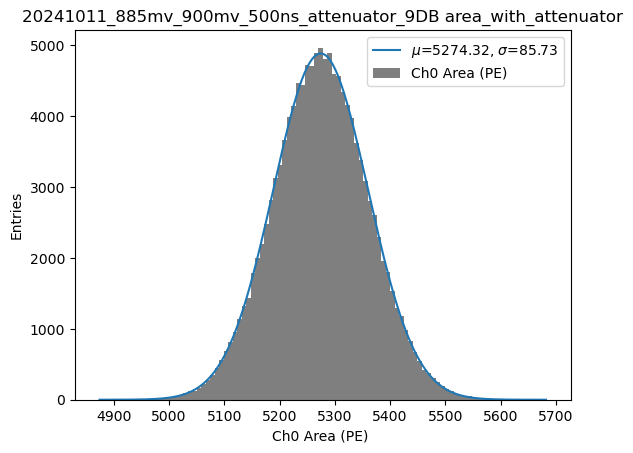

Fit: mu= 5274.32, sigma =85.73


In [17]:
#Ch0_area_pe_mu, Ch0_area_pe_sigma =  analysis_data.plot_fit_histgram_vs_Gaussion(area_ch0, 100, 100 , 6000 , [1.e4, 2500, 50 ], file_tag=file_tag, xlabel='Ch0 Area (PE)', title='area_with_attenuator',Save=True)
Ch0_area_pe_mu, Ch0_area_pe_sigma =  analysis_data.plot_fit_histgram_vs_Gaussion(area_ch0, 100, left_edge_ch0 ,right_edge_ch0 , [amplitude_ch0, mean_ch0, std_ch0 ], file_tag=file_tag, xlabel='Ch0 Area (PE)', title='area_with_attenuator',Save=False)


In [18]:
Ch0_area_pe_mu, Ch0_area_pe_sigma 

(5274.319598916058, 85.7252188576149)

In [19]:
mean_ch1, std_ch1 ,left_edge_ch1 , right_edge_ch1, nbins_ch1, amplitude_ch1

(64.17651852036118,
 8.53457463904471,
 30.735127332714715,
 110.56809980410353,
 80,
 128668)

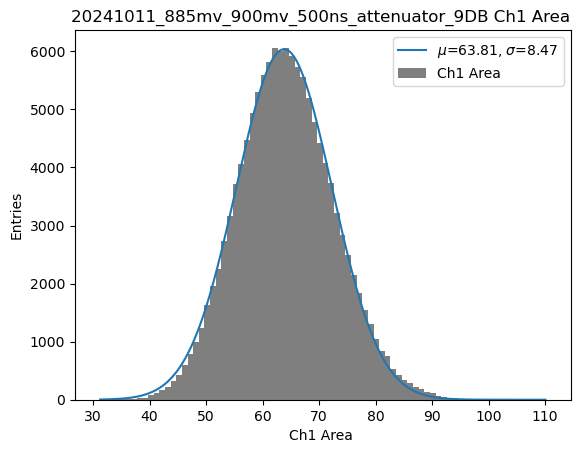

Fit: mu= 63.81, sigma =8.47


In [20]:
#Ch1_area_pe_mu, Ch1_area_pe_sigma =  analysis_data.plot_fit_histgram_vs_Gaussion(area_ch1, 100, 0 , 300 , [1e4, 120, 10 ], file_tag=file_tag, xlabel='Ch1 Area', title='Ch1 Area ')
Ch1_area_pe_mu, Ch1_area_pe_sigma =  analysis_data.plot_fit_histgram_vs_Gaussion(area_ch1, nbins_ch1, left_edge_ch1 , right_edge_ch1 , [amplitude_ch1, mean_ch1, std_ch1 ], file_tag=file_tag, xlabel='Ch1 Area', title='Ch1 Area ')


In [21]:
Ch1_area_pe_mu, Ch1_area_pe_sigma

(63.80539154495383, 8.466635861143182)

# store the run info to DateFrame

In [22]:
Ratio_fit_mu = Ch0_area_pe_mu/Ch1_area_pe_mu 
Ratio_fit_sigma= Ratio_fit_mu* np.sqrt((Ch0_area_pe_sigma / Ch0_area_pe_mu )**2  + (Ch1_area_pe_sigma / Ch1_area_pe_mu )**2 )

In [23]:
Ch0_area_pe_mu, Ch0_area_pe_sigma, Ch1_area_pe_mu, Ch1_area_pe_sigma, Ch2_area_pe_mu, Ch2_area_pe_sigma, Ratio_fit_mu , Ratio_fit_sigma,file_tag

(5274.319598916058,
 85.7252188576149,
 63.80539154495383,
 8.466635861143182,
 43.280474831884945,
 1.6206975312637928,
 82.66260062364883,
 11.050863767963715,
 '20241011_885mv_900mv_500ns_attenuator_9DB')

In [24]:
run_info.append({
        'Ch0_Area_mu': Ch0_area_pe_mu,
        'Ch0_Area_sigma': Ch0_area_pe_sigma,
        'Ch1_Area_mu': Ch1_area_pe_mu,
        'Ch1_Area_sigma': Ch1_area_pe_sigma,
        'Ch2_Area_mu': Ch2_area_pe_mu,
        'Ch2_Area_sigma': Ch2_area_pe_sigma,
        'Ratio_fit_mu': Ratio_fit_mu,
        'Ratio_fit_sigma': Ratio_fit_sigma,
        #'Gain_ratio_fit_mu': gain_ratio_fit_mu,
        #'Gain_ratio_fit_sigma': gain_ratio_fit_sigma,
        'file_tag': file_tag            
    })

In [25]:
df0 = pd.DataFrame(run_info)
df0

,Ch0_Area_mu,Ch0_Area_sigma,Ch1_Area_mu,Ch1_Area_sigma,Ch2_Area_mu,Ch2_Area_sigma,Ratio_fit_mu,Ratio_fit_sigma,file_tag
0,5274.319599,85.725219,63.805392,8.466636,43.280475,1.620698,82.662601,11.050864,20241011_885mv_900mv_500ns_attenuator_9DB


In [416]:
df0.sort_values('Ch0_Area_mu')

,Ch0_Area_mu,Ch0_Area_sigma,Ch1_Area_mu,Ch1_Area_sigma,Ch2_Area_mu,Ch2_Area_sigma,Ratio_fit_mu,Ratio_fit_sigma,file_tag
4,1328.480595,42.366222,15.837159,4.274474,9.192873,1.070535,83.883769,22.797855,20241011_850mv_900mv_400ns_attenuator_9DB
9,1369.295253,50.832460,16.325104,4.386874,9.570155,1.080386,83.876663,22.753360,20241011_850mv_900mv_500ns_attenuator_9DB
1,3325.289175,66.302801,40.412134,6.730397,25.908304,1.146581,82.284424,13.801837,20241011_900mv_900mv_300ns_attenuator_9DB
5,3360.633272,71.304690,40.912633,6.794049,23.252892,1.170335,82.141700,13.751536,20241011_880mv_900mv_400ns_attenuator_9DB
6,3669.726246,74.641918,44.663074,7.040324,25.501884,1.193173,82.164660,13.059147,20241011_885mv_900mv_400ns_attenuator_9DB
10,3726.453063,71.790342,44.971769,7.204011,29.903680,1.552761,82.862052,13.369287,20241011_870mv_900mv_500ns_attenuator_9DB
8,4005.092532,78.823184,48.760020,7.373533,27.973266,1.217342,82.138861,12.525862,20241011_888mv_900mv_400ns_attenuator_9DB
0,4240.027807,74.845498,51.723968,7.557563,33.555260,1.185291,81.974141,12.064609,20241011_910mv_900mv_300ns_attenuator_9DB
7,4359.827098,82.345783,53.172958,7.666091,30.639560,1.243858,81.993315,11.922210,20241011_890mv_900mv_400ns_attenuator_9DB
2,5487.015161,93.233118,67.348663,8.615661,39.569866,1.338396,81.471776,10.513911,20241011_900mv_900mv


In [284]:
import process_data
path = 'outnpy/df_100ns_900mv_20240924_backup.h5py'
df = pd.read_hdf(path, key='winfo')
# process_data.write_to_hdf5(df0, path) 

In [285]:
area_1 = df.Ch0_Area_mu > 2500
area_2 = df.Ch0_Area_mu < 3500

In [163]:
df.file_tag[area_1 & area_2], df.Ch0_Area_mu[area_1 & area_2]

(5    20240924_1.010V_900mv_100ns_attenuator_9DB
 Name: file_tag, dtype: object,
 5    2991.136207
 Name: Ch0_Area_mu, dtype: float64)

In [164]:
# import process_data
# import pandas as pd
# df_path = 'outnpy/df_100ns_900mv_20240924_tmp.h5py'
# #path = 'outnpy/attenuator_calibration.h5py'
# df_larger_area = pd.read_hdf(df_path, key='winfo')
# #df_attenuator = pd.read_hdf(path, key='winfo')
# df_larger_area[:40]
# #df_attenuator.head()

In [165]:
df_larger_area.sort_values('Ch0_Area_mu')

NameError: name 'df_larger_area' is not defined

In [ ]:
# df_larger_area = pd.concat([df_larger_area, df0], axis=0)

In [ ]:
df_larger_area[0:]

,Ch0_Area_mu,Ch0_Area_sigma,Ch1_Area_mu,Ch1_Area_sigma,Ch2_Area_mu,Ch2_Area_sigma,Ratio_fit_mu,Ratio_fit_sigma,file_tag
0,4996.692712,51.831023,71.831750,8.732552,50.218766,1.262149,69.561061,8.487233,20240924_1.050V_900mv_100ns_attenuator_9DB
1,4558.733190,54.319974,62.234172,8.161690,43.141526,1.231217,73.251287,9.646099,20240924_1.040V_900mv_100ns_attenuator_9DB
2,5409.963700,48.787700,82.514968,9.412742,58.293035,1.300190,65.563422,7.502361,20240924_1.060V_900mv_100ns_attenuator_9DB
3,4082.233209,56.095315,53.324819,7.580448,36.649350,1.203854,76.554094,10.933355,20240924_1.030V_900mv_100ns_attenuator_9DB
4,3597.306024,56.670779,45.397648,6.988979,30.966531,1.173257,79.239921,12.262710,20240924_1.020V_900mv_100ns_attenuator_9DB
5,2991.136207,55.689459,36.610339,6.293250,24.826213,1.142458,81.701954,14.126553,20240924_1.010V_900mv_100ns_attenuator_9DB
6,1216.805413,38.637041,14.196193,3.954167,9.859086,1.058253,85.713503,24.029028,20240924_965mv_900mv_100ns_attenuator_9DB
7,1724.577599,45.655745,20.392685,4.720816,13.893644,1.082363,84.568442,19.704820,20240924_980mv_900mv_100ns_attenuator_9DB
8,784.448286,31.079364,9.001924,3.215555,6.530890,1.045959,87.142293,31.318763,20240924_950mv_900mv_100ns_attenuator_9DB
9,2391.849657,52.240849,28.820353,5.612226,19.405815,1.099492,82.991684,16.262418,20240924_1.000V_900mv_100ns_attenuator_9DB


In [ ]:
# path = 'outnpy/df_100ns_900mv_9DB_20240920_20240924_tmp.h5py'
# process_data.write_to_hdf5(df_larger_area, path)

h5 Write Time: 0.01 s 
h5 File Size: 1.03 MB
Save to outnpy/df_100ns_900mv_9DB_20240920_20240924_tmp.h5py


(0.01057291030883789, 1077177)

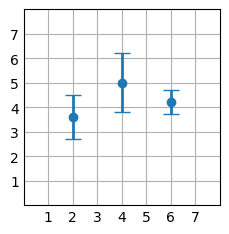

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# make data:
np.random.seed(1)
x = [2, 4, 6]
y = [3.6, 5, 4.2]
yerr = [0.9, 1.2, 0.5]

# plot:
fig, ax = plt.subplots()

ax.errorbar(x, y, yerr, fmt='o', linewidth=2, capsize=6)

ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
       ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()